In [1]:
import numpy as np
from scipy.linalg import block_diag
import time
import matplotlib.pyplot as plt

In [3]:
def TSQR(A):
    """
    TSQR with 4 blocks of rows:
    Stage 1:  Wi = Qi0 * Ri0   for i=0..3
    Stage 2: Sequential reduction
      Step 1: [R00; R10] = Q01 * R01
      Step 2: [R01; R20] = Q02 * R02
      Step 3: [R02; R30] = Q03 * R03
    Stage 3: Q assembled so that A ≈ Q R
           R = R03
    """
    A = np.asarray(A)
    m, n = A.shape
    # Split rows into 4 blocks using row sub-indexing
    row_blocks = np.array_split(np.arange(m), 4)

    # Stage 1: QR on each Wi
    Q00, R00 = np.linalg.qr(A[row_blocks[0], :], mode="reduced")
    Q10, R10 = np.linalg.qr(A[row_blocks[1], :], mode="reduced")
    Q20, R20 = np.linalg.qr(A[row_blocks[2], :], mode="reduced")
    Q30, R30 = np.linalg.qr(A[row_blocks[3], :], mode="reduced")
    # Stage 2 (Step 1): [R00; R10] = Q01 * R01
    Q01, R01 = np.linalg.qr(np.vstack([R00, R10]), mode="reduced")
    X0 = Q01[:n, :]     # top n rows
    X1 = Q01[n:, :]     # bottom n rows
    # Stage 2 (Step 2): [R01; R20] = Q02 * R02
    Q02, R02 = np.linalg.qr(np.vstack([R01, R20]), mode="reduced")
    Y0 = Q02[:n, :]     # top n rows
    Y1 = Q02[n:, :]     # bottom n rows
    # Stage 2 (Step 3): [R02; R30] = Q03 * R03
    Q03, R03 = np.linalg.qr(np.vstack([R02, R30]), mode="reduced")
    Z0 = Q03[:n, :]     # top n rows
    Z1 = Q03[n:, :]     # bottom n rows
    # Stage 3:
    # Multipliers for each block 
    A0 = X0 @ Y0 @ Z0
    A1 = X1 @ Y0 @ Z0
    A2 = Y1 @ Z0
    A3 = Z1
    
    Q = np.vstack([
    Q00 @ A0,
    Q10 @ A1,
    Q20 @ A2,
    Q30 @ A3
    ])                  
    # Final R is last-stage R
    R = R03
    return Q, R



### TSQR (Sequential Version)

Let $A \in \mathbb{R}^{m \times n}$ and split its rows into 4 blocks
$W_0, W_1, W_2, W_3$ with sizes $m_0, m_1, m_2, m_3$.

$$
A =
\begin{bmatrix}
W_0\\
W_1\\
W_2\\
W_3
\end{bmatrix},
\qquad
m = m_0 + m_1 + m_2 + m_3.
$$

---

#### Stage 1 (local QR)

For each row block $W_i$,
$$
W_i = Q_{i0} R_{i0}, \qquad i=0,1,2,3.
$$

Shapes:
- $Q_{i0} \in \mathbb{R}^{m_i \times n}$
- $R_{i0} \in \mathbb{R}^{n \times n}$

---

#### Sequential reduction (chain on the small $R$'s)

**Step 1: combine blocks 0 and 1**
$$
\begin{bmatrix}
R_{00}\\
R_{10}
\end{bmatrix}
=
Q_{01} R_{01},
\qquad
Q_{01}\in\mathbb{R}^{2n\times n}.
$$

Split $Q_{01}$ into top/bottom $n\times n$ blocks:
$$
Q_{01}=
\begin{bmatrix}
X_0\\
X_1
\end{bmatrix},
\qquad
X_0,X_1\in\mathbb{R}^{n\times n}.
$$

**Step 2: combine the result with block 2**
$$
\begin{bmatrix}
R_{01}\\
R_{20}
\end{bmatrix}
=
Q_{02} R_{02},
\qquad
Q_{02}\in\mathbb{R}^{2n\times n}.
$$

Split $Q_{02}$ into top/bottom $n\times n$ blocks:
$$
Q_{02}=
\begin{bmatrix}
Y_0\\
Y_1
\end{bmatrix},
\qquad
Y_0,Y_1\in\mathbb{R}^{n\times n}.
$$

**Step 3: combine the result with block 3**
$$
\begin{bmatrix}
R_{02}\\
R_{30}
\end{bmatrix}
=
Q_{03} R_{03},
\qquad
Q_{03}\in\mathbb{R}^{2n\times n}.
$$

Split $Q_{03}$ into top/bottom $n\times n$ blocks:
$$
Q_{03}=
\begin{bmatrix}
Z_0\\
Z_1
\end{bmatrix},
\qquad
Z_0,Z_1\in\mathbb{R}^{n\times n}.
$$

---

#### Final $Q$ and $R$

$$
R = R_{03}.
$$

$$
Q=
\begin{bmatrix}
Q_{00}\,X_0Y_0Z_0\\
Q_{10}\,X_1Y_0Z_0\\
Q_{20}\,Y_1Z_0\\
Q_{30}\,Z_1
\end{bmatrix}.
$$


In [6]:
rng = np.random.default_rng(0)
A = rng.standard_normal((120, 10))

Q, R = TSQR(A)
# Computes the relative reconstruction error
print("||A - QR|| / ||A|| =", np.linalg.norm(A - Q@R) / np.linalg.norm(A))
# Checks orthonormality of Q
print("||Q^T Q - I||      =", np.linalg.norm(Q.T@Q - np.eye(A.shape[1])))


||A - QR|| / ||A|| = 4.0435521617916764e-16
||Q^T Q - I||      = 1.6407614839933977e-15


In [119]:
# Create a random number generator with seed 0
rng = np.random.default_rng(0)
n_fixed = 50
m_values = [200,2000,20000,200000,2000000]  
times_m = []
for m in m_values:
    A = rng.uniform(-100.0, 100.0, size=(m, n_fixed))
    t_listn = []
    for _ in range(5):
        t_start = time.perf_counter()
        Q, R = TSQR(A)
        t_end = time.perf_counter()
        t_listn.append(t_end - t_start)
    times_m.append(sum(t_listn)/len(t_listn))
    print(f"m={m}, n={n_fixed}, time={times_m[-1]:.6f}s")


m=200, n=50, time=0.043676s
m=2000, n=50, time=0.008615s
m=20000, n=50, time=0.062329s
m=200000, n=50, time=0.421328s
m=2000000, n=50, time=5.255154s


In [115]:
rng = np.random.default_rng(1)
n_values = [5, 10, 50, 100, 500,1000]
m_fixed = 800000
times_n = []
for n in n_values:
    A = rng.uniform(-100.0, 100.0, size=(m_fixed, n)) 
    t_listm = []
    for _ in range(5):
        t_start = time.perf_counter()
        Q, R = TSQR(A)
        t_end = time.perf_counter()
        t_listm.append(t_end - t_start)
    times_n.append(sum(t_listm)/len(t_listn))
    print(f"m={m_fixed}, n={n}, time={times_n[-1]:.6f}s")


m=800000, n=5, time=0.113452s
m=800000, n=10, time=0.244117s
m=800000, n=50, time=2.106903s
m=800000, n=100, time=8.012561s
m=800000, n=500, time=56.979578s
m=800000, n=1000, time=220.986018s


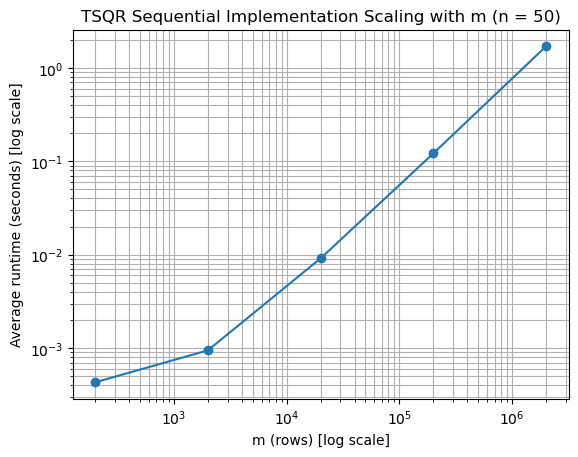

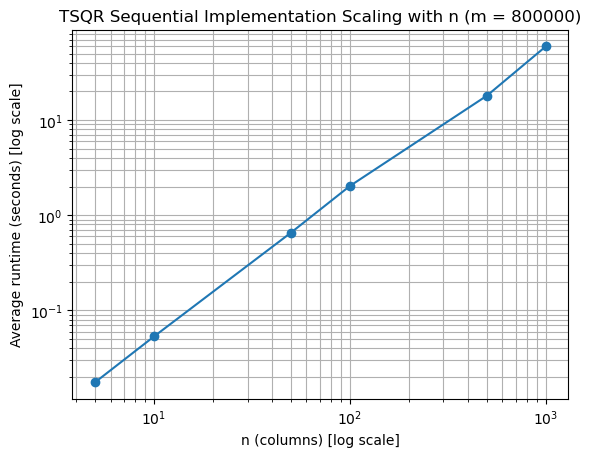

In [83]:
# Plot 1: scaling with m (n fixed)
plt.figure()
plt.loglog(m_values, times_m, marker="o")
plt.xlabel("m (rows) [log scale]")
plt.ylabel("Average runtime (seconds) [log scale]")
plt.title(f"TSQR Sequential Implementation Scaling with m (n = {n_fixed})")
plt.grid(True, which="both")
plt.savefig("Sequantial_n_fixed.png")
plt.show()

# Log-log: scaling with n (m fixed)
plt.figure()
plt.loglog(n_values, times_n, marker="o")
plt.xlabel("n (columns) [log scale]")
plt.ylabel("Average runtime (seconds) [log scale]")
plt.title(f"TSQR Sequential Implementation Scaling with n (m = {m_fixed})")
plt.grid(True, which="both")
plt.savefig("Sequantial_m_fixed.png")
plt.show()


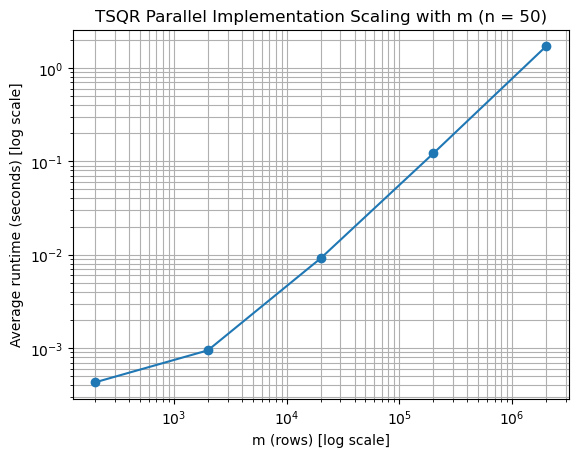

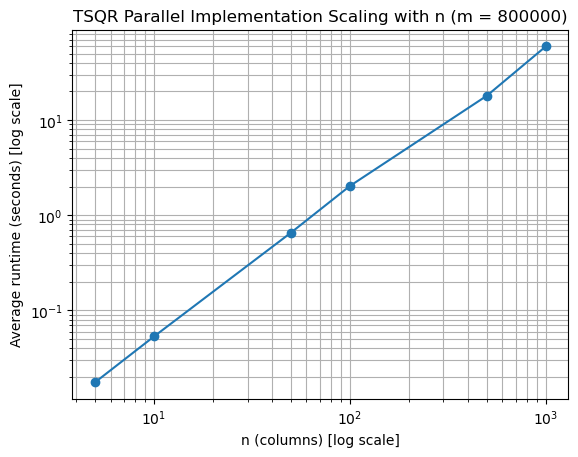

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Parallel Implemented TSQR Data -----
# scaling with m (fixed n=50)
m_values = np.array([200, 2000, 20000, 200000, 2000000], dtype=float)
times_m  = np.array([0.000430, 0.000946, 0.009134, 0.121516, 1.702822], dtype=float)
n_fixed = 50

# scaling with n (fixed m=800000)
n_values = np.array([5, 10, 50, 100, 500, 1000], dtype=float)
times_n  = np.array([0.017580, 0.053286, 0.656571, 2.032144,18.046634, 59.516151], dtype=float)
m_fixed = 800000

# Plot 1: scaling with m (n fixed)
plt.figure()
plt.loglog(m_values, times_m, marker="o")
plt.xlabel("m (rows) [log scale]")
plt.ylabel("Average runtime (seconds) [log scale]")
plt.title(f"TSQR Parallel Implementation Scaling with m (n = {n_fixed})")
plt.grid(True, which="both")
plt.savefig("Parallel_n_fixed.png")
plt.show()

# Plot 2: scaling with n (m fixed)
plt.figure()
plt.loglog(n_values, times_n, marker="o")
plt.xlabel("n (columns) [log scale]")
plt.ylabel("Average runtime (seconds) [log scale]")
plt.title(f"TSQR Parallel Implementation Scaling with n (m = {m_fixed})")
plt.grid(True, which="both")
plt.savefig("Parallel_m_fixed.png")
plt.show()
